In [1]:
import nglview as nv
import glob
import mdtraj as md
import os

In [2]:
model_ckpt = 'PentaPeptideHeavySweepFinal/gen=256_dis=512_latent=128_genNet=simple_disNet=simple_opt=rmsprop/checkpoints/epoch=66704-step=6737205.ckpt'

In [3]:
trj_dir = 'PentaPeptideHeavySweepFinal/gen=256_dis=512_latent=128_genNet=simple_disNet=simple_opt=rmsprop/trjs/trj*xyz'

In [4]:
trj_fnames = glob.glob(trj_dir)
trj_fnames.sort(key=os.path.getmtime)

In [5]:
full_trj = md.load('data_mdshare/pentapeptide-impl-solv.pdb')
full_trj

<mdtraj.Trajectory with 1 frames, 94 atoms, 5 residues, and unitcells at 0x7f3111219ef0>

In [6]:
cond_trj = full_trj.atom_slice(full_trj.top.select_atom_indices('heavy'))

In [7]:
trj = md.load(trj_fnames[-1], top=full_trj.top)
trj

<mdtraj.Trajectory with 25005 frames, 94 atoms, 5 residues, without unitcells at 0x7f3111219fd0>

In [8]:
v = nv.show_mdtraj(trj.center_coordinates())
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=25004)

In [9]:
from GAN_datamodule import PentaPeptideHeavy

In [10]:
data = PentaPeptideHeavy()

Using 20 trajectories for training consisting of 100020 frames
Using 5 trajectories for evaluation consisting of 25005 frames
Generating 4-dim TICA embedding as the conditioning


calculate covariances:   0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
# compare reconstructed traj against conditioning
from nglview import NGLWidget
view = NGLWidget()
view.add_trajectory(data.val_trj)
view.add_trajectory(trj)
op_list = [0.4, 1.0]
for v, op in zip(view, op_list):
    v.clear_representations()
    v.add_representation('ball+stick', opacity=op)
view

NGLWidget(max_frame=25004)

In [12]:
961, 7812,19144

(961, 7812, 19144)

In [13]:
v = nv.show_mdtraj(data.val_trj)
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=25004)

In [14]:
import pickle as pkl
from copy import deepcopy
import numpy as np

In [15]:
ddpm = pkl.load(open('/project/andrewferguson/Mike/geometric_deep_learning/DDPM/test_trajs/pep-aa.pkl','rb'))

In [16]:
data.val_trj

<mdtraj.Trajectory with 25005 frames, 94 atoms, 5 residues, and unitcells at 0x7f2fb66d1f98>

In [17]:
ddpm.center_coordinates()

<mdtraj.Trajectory with 25005 frames, 94 atoms, 5 residues, without unitcells at 0x7f30400a4ef0>

In [18]:
trj.center_coordinates()

<mdtraj.Trajectory with 25005 frames, 94 atoms, 5 residues, without unitcells at 0x7f3111219fd0>

In [19]:
val_trj = deepcopy(data.val_trj.center_coordinates())

In [20]:
combined_top = val_trj.top.join(trj.top).join(ddpm.top)
combined_top

<mdtraj.Topology with 3 chains, 15 residues, 282 atoms, 285 bonds at 0x7f2fb5d90c50>

In [21]:
gan_xyz = trj.xyz +  + np.array([[0, 1.75, 0]])
ddpm_xyz = ddpm.xyz +  + np.array([[0, 3.5, 0]])

In [22]:
gan_xyz.shape

(25005, 94, 3)

In [23]:
combined_xyz = np.concatenate((val_trj.xyz, gan_xyz, ddpm_xyz), 1)
combined_xyz.shape

(25005, 282, 3)

In [24]:
combined_trj = md.Trajectory(combined_xyz, topology=combined_top)

In [75]:
v = nv.show_mdtraj(combined_trj)
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=25004)

In [25]:
import numpy as np
from scipy.spatial.distance import pdist

In [26]:
pdists_real = np.concatenate([pdist(xyz)[None] for xyz in data.val_cond_trj.xyz])
pdists_fake = np.concatenate([pdist(xyz)[None] for xyz in trj.atom_slice(data.cond_idxs).xyz])

In [27]:
TICS_real = data.tica_estimator.transform(pdists_real)
TICS_fake = data.tica_estimator.transform(pdists_fake)

In [28]:
import pyemma as py
import matplotlib.pyplot as plt

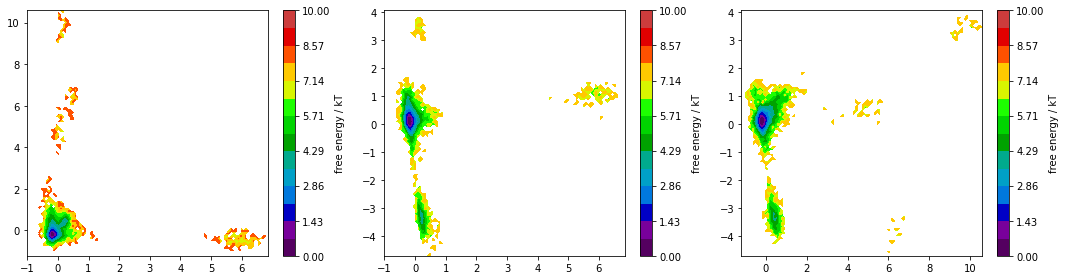

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()
py.plots.plot_free_energy(TICS_real[:,0], TICS_real[:,1], levels=np.linspace(0, 10, 15), ax=ax[0])
py.plots.plot_free_energy(TICS_real[:,0], TICS_real[:,2], levels=np.linspace(0, 10, 15), ax=ax[1])
py.plots.plot_free_energy(TICS_real[:,1], TICS_real[:,2], levels=np.linspace(0, 10, 15), ax=ax[2])
plt.tight_layout()

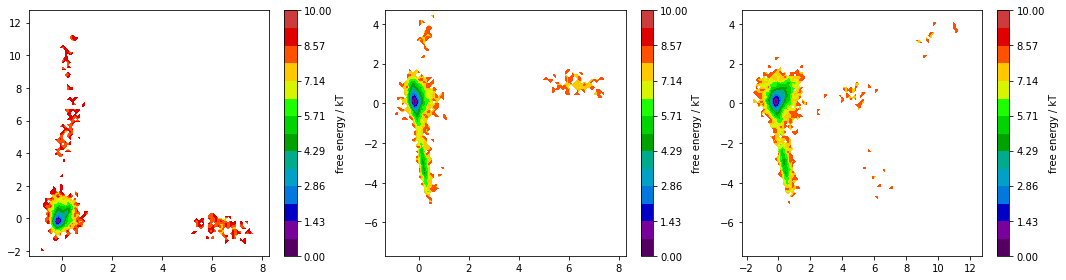

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()
py.plots.plot_free_energy(TICS_fake[:,0], TICS_fake[:,1], levels=np.linspace(0, 10, 15), ax=ax[0])
py.plots.plot_free_energy(TICS_fake[:,0], TICS_fake[:,2], levels=np.linspace(0, 10, 15), ax=ax[1])
py.plots.plot_free_energy(TICS_fake[:,1], TICS_fake[:,2], levels=np.linspace(0, 10, 15), ax=ax[2])
plt.tight_layout()

/project/andrewferguson/Kirill/class_project_env/lib/python3.7/site-packages/pyemma/plots/plots2d.py:253: UserWarning: bins=25 is not an allowed optional parameter and will be ignored
  ' be ignored'.format(key, kwargs[key]))


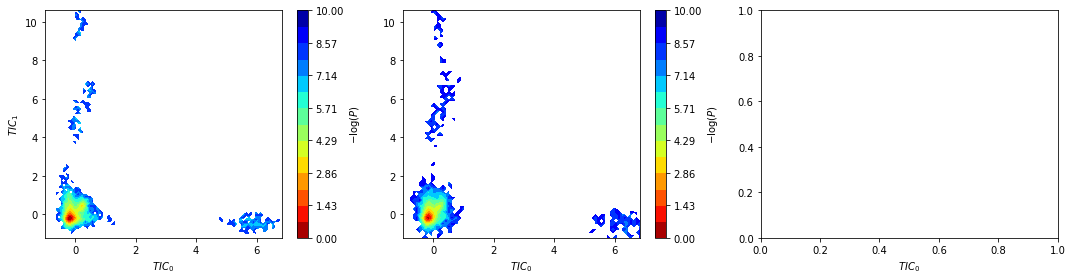

In [31]:

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()
py.plots.plot_free_energy(TICS_real[:, 0], TICS_real[:, 1], levels=np.linspace(0, 10, 15),
                          bins=25, ax=ax[0], cbar_label=r'$-\log(P)$', cmap='jet_r')
py.plots.plot_free_energy(TICS_fake[:, 0], TICS_fake[:, 1],  levels=np.linspace(0, 10, 15),
                          bins=25, ax=ax[1], cbar_label=r'$-\log(P)$', cmap='jet_r')
x_lim = ax[0].get_xlim()
y_lim = ax[0].get_ylim()
ax[1].set_xlim(*x_lim)
ax[1].set_ylim(*y_lim)
ax[0].set_ylabel(r'$TIC_1$')
for a in ax:
    a.set_xlabel(r'$TIC_0$')
plt.tight_layout()

In [32]:
from scipy.stats import pearsonr

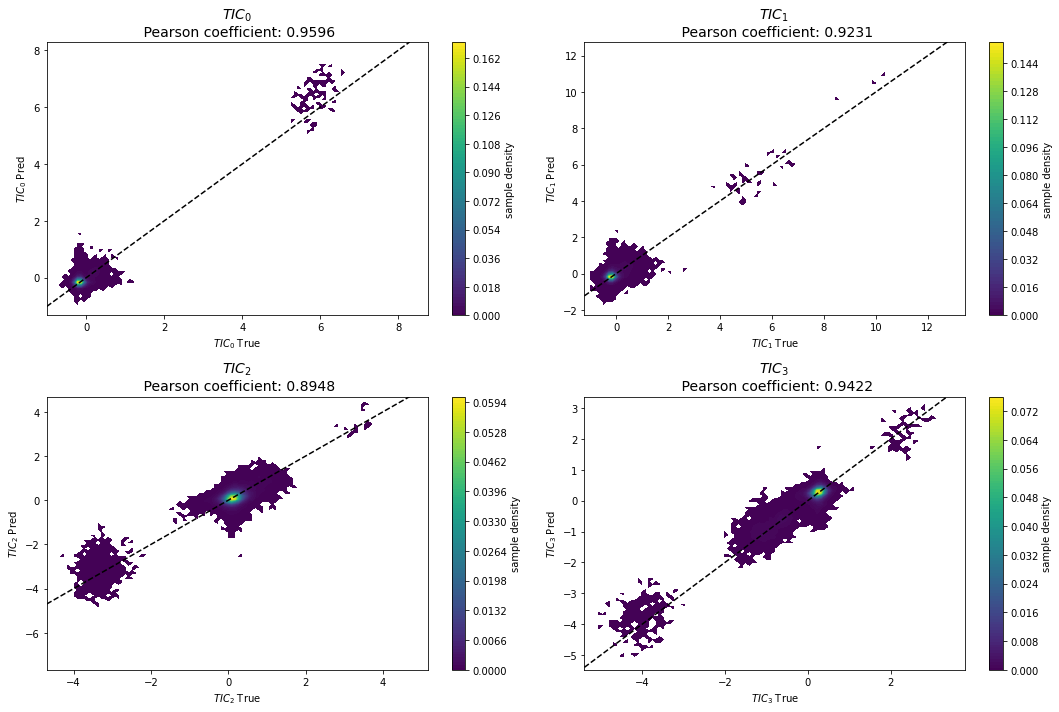

In [33]:
fig, axes = plt.subplots(2,2, figsize=(15, 10))
corrs = list()
for tic_idx, ax in enumerate(axes.flatten()):
    py.plots.plot_density(TICS_real[:, tic_idx], TICS_fake[:, tic_idx], ax=ax)
    p_phi, _ = pearsonr(TICS_real[:, tic_idx], TICS_fake[:, tic_idx])
    corrs.append(p_phi)
    ax.set_title(f'$TIC_{tic_idx}$ \n Pearson coefficient: {p_phi:.4g}', fontsize=14)
    ax.set_xlabel(f'$TIC_{tic_idx}$ True')
    ax.set_ylabel(f'$TIC_{tic_idx}$ Pred')
    y_min,y_max = ax.get_ylim()
    x_min,x_max = ax.get_xlim()
    ax.plot([x_min, y_max], [x_min,y_max], c='k', linestyle='--')
plt.tight_layout()

In [34]:
np.mean(corrs)

0.9299217301116651

In [35]:
def empirical_correlation(x, y):
    xc = x - np.mean(x, axis=0)
    yc = y - np.mean(y, axis=0)
    corr = np.mean(xc*yc, axis=0)/(np.std(x, axis=0)*np.std(y, axis=0))
    return corr


def generate_its(data, lags):
    its = []
    for lag in lags: 
        if type(data) is list:
            x0 = np.concatenate([item[:-lag] for item in data])
            x1 = np.concatenate([item[lag:] for item in data])
        else:
            x0 = data[:-lag]
            x1 = data[lag:]
        ts = empirical_correlation(x0, x1)
        its.append(-lag/np.log(np.abs(ts)))
    
    return np.array(its)

In [36]:
lags = [1,5,10,15,20,25,30,35,40]

In [37]:
real_its = generate_its([x for x in TICS_real.reshape(5, -1, 4)], lags)
fake_its = generate_its([x for x in TICS_fake.reshape(5, -1, 4)], lags)

Text(0.5, 0, 'Lag time')

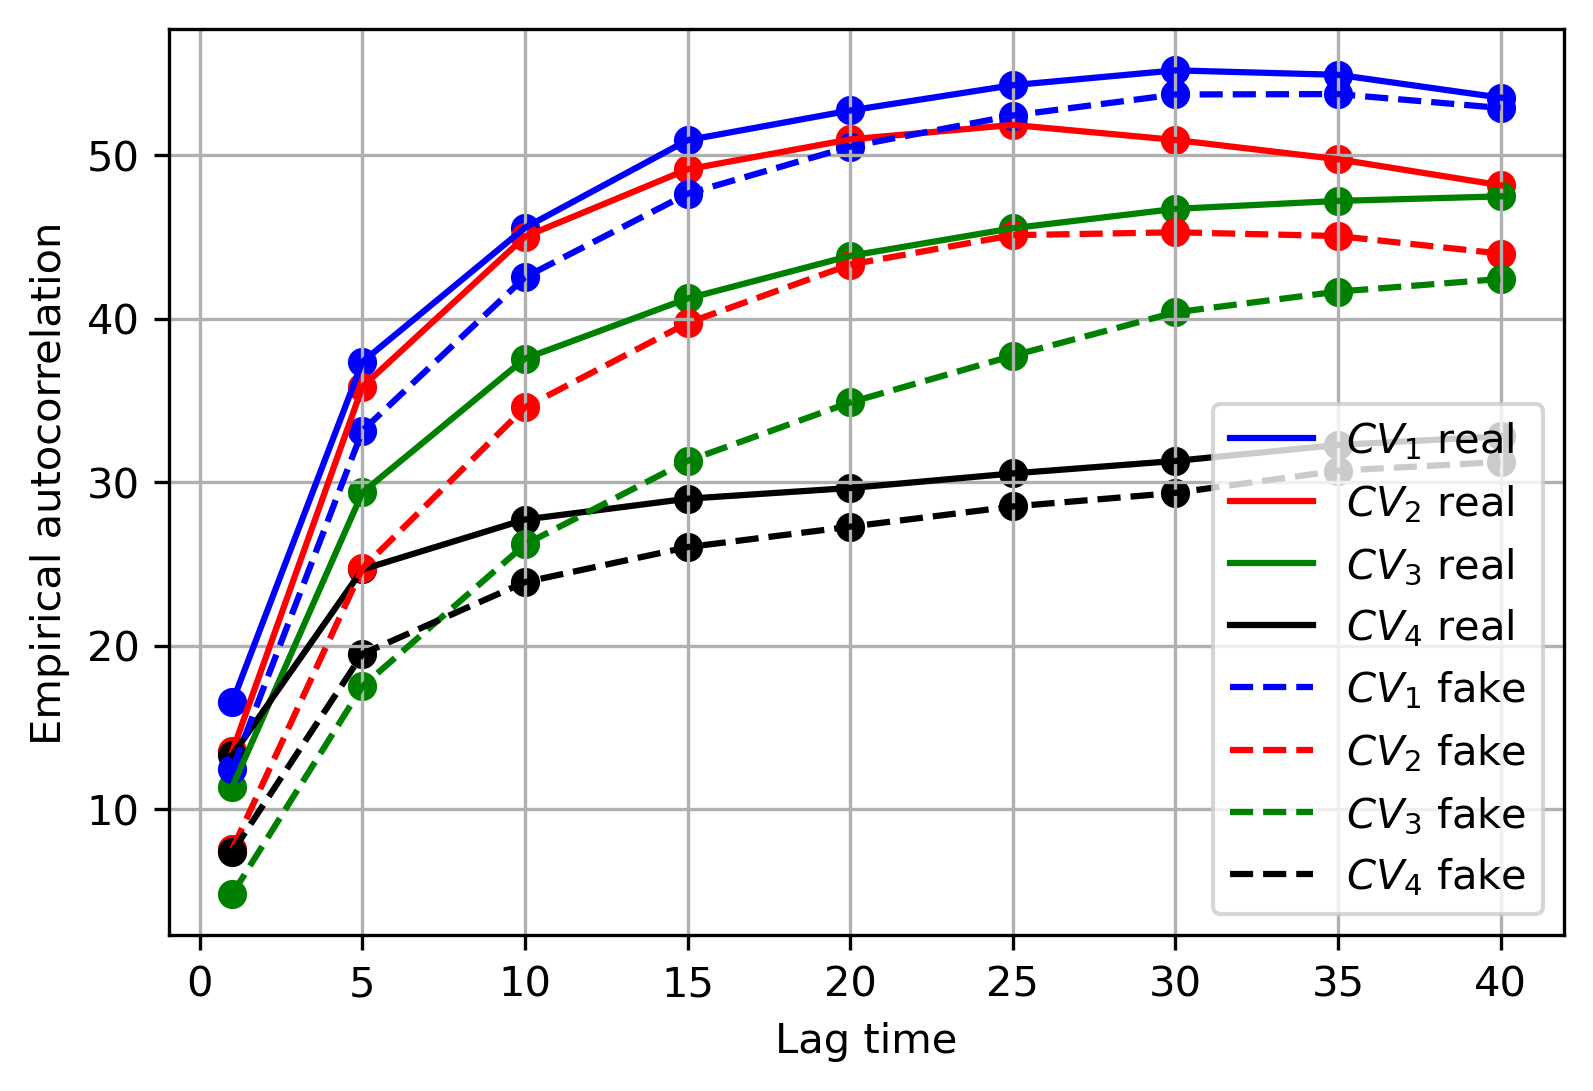

In [38]:
plt.figure(dpi=300)
colors = ['b','r', 'g', 'k']
for i in range(real_its.shape[1]):
    plt.plot(lags,real_its[:, i], label=f'$CV_{i+1}$ real', c=colors[i])
    plt.scatter(lags,real_its[:, i], c=colors[i])

for i in range(fake_its.shape[1]):
    plt.plot(lags,fake_its[:, i], label=f'$CV_{i+1}$ fake', linestyle='--', c=colors[i])
    plt.scatter(lags,fake_its[:, i], c=colors[i])

plt.legend()
plt.grid()
plt.ylabel('Empirical autocorrelation')
plt.xlabel('Lag time')

In [39]:
from GAN_model import WGANGP
import torch

In [40]:
model = WGANGP.load_from_checkpoint(model_ckpt)
model.eval()

WGANGP(
  (generator): SimpleGenerator(
    (model): Sequential(
      (0): Linear(in_features=132, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Linear(in_features=256, out_features=282, bias=True)
      (10): Tanh()
    )
  )
  (discriminator): SimpleDiscriminator(
    (model): Sequential(
      (0): Linear(in_features=286, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): SiLU()
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): SiLU()
      (6)

In [41]:
N = 1000
i = 0

In [42]:
TICS_real[i][None]

array([[-0.23692961, -0.1841856 , -0.29917094,  0.13388295]],
      dtype=float32)

In [43]:
c = TICS_real[i][None]
c = torch.tensor(data.condition_scaler.transform(c)).float().repeat(N,1)
z = torch.randn(N, 128)

In [44]:
xyz_noise = model.forward(z, c).detach().cpu().numpy()
xyz_noise = data.xyz_scaler.inverse_transform(xyz_noise)
xyz_noise = xyz_noise.reshape(N, -1, 3)

In [45]:
trj_noise = md.Trajectory(xyz=xyz_noise, topology=data.val_trj.top).center_coordinates()

In [46]:
trj_noise.save_pdb('trj_noise_heavy.pdb')

In [47]:
data.val_trj[i].atom_slice(data.cond_idxs).center_coordinates().save_pdb('trj_noise_heavy_condition_frame.pdb')

In [48]:
# compare reconstructed traj against conditioning
from nglview import NGLWidget
view = NGLWidget()
view.add_trajectory(data.val_trj[i].atom_slice(data.cond_idxs))
view.add_trajectory(trj_noise.atom_slice(data.cond_idxs))
op_list = [0.4, 1.0]
for v, op in zip(view, op_list):
    v.clear_representations()
    v.add_representation('ball+stick', opacity=op)
view

NGLWidget(max_frame=999)

In [107]:
pdists_noise = np.concatenate([pdist(xyz)[None] for xyz in trj_noise.atom_slice(data.cond_idxs).xyz])

In [108]:
TICS_noise = data.tica_estimator.transform(pdists_noise)

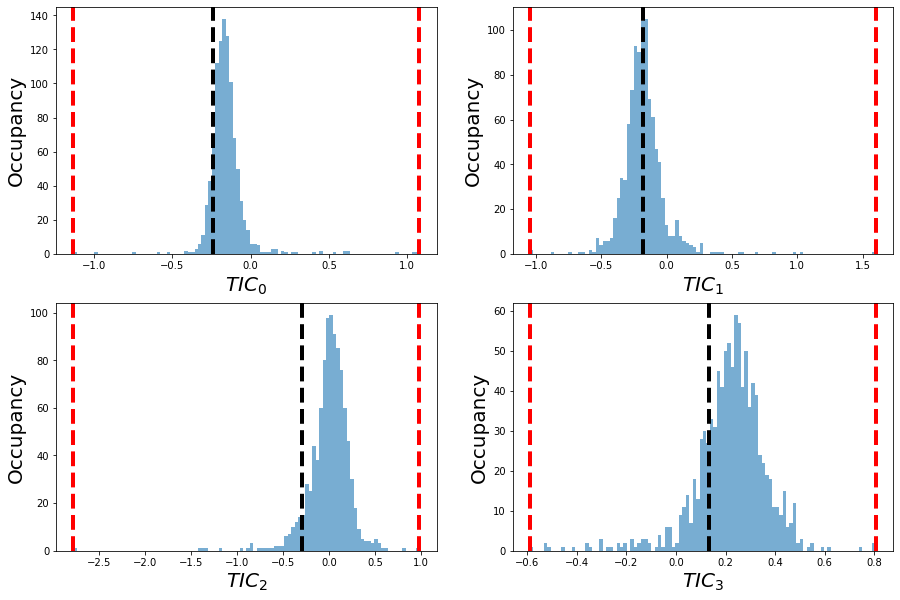

In [118]:
fig, axes = plt.subplots(2,2, figsize=(15, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(TICS_noise[:,i], bins=100, alpha=0.6)
    ax.axvline(x=TICS_real[0][i], c='k', linestyle='--', linewidth=4)
    ax.set_xlabel(f'$TIC_{i}$', fontsize=20)
    ax.set_ylabel('Occupancy', fontsize=20)
    ax.axvline(x=np.min(TICS_noise[:,i]), c='r', linestyle='--', linewidth=4)
    ax.axvline(x=np.max(TICS_noise[:,i]), c='r', linestyle='--', linewidth=4)

In [117]:
for ax in axes:
    print(ax.get_xlim())

(-1.2398181140422821, 1.1872216641902924)
(-1.1780646562576294, 1.7343915224075317)
(-2.9715616583824156, 1.1730079531669617)
(-0.6577425241470337, 0.8756436347961426)


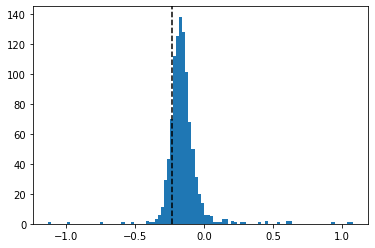

In [109]:
plt.hist(TICS_noise[:,0], bins=100)
plt.axvline(x=TICS_real[0][], c='k', linestyle='--')

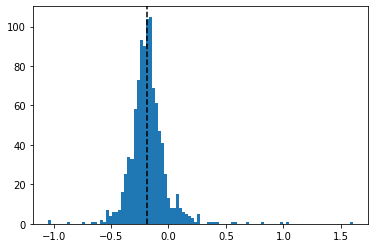

In [110]:
plt.hist(TICS_noise[:,1], bins=100)
plt.axvline(x=TICS_real[0][1], c='k', linestyle='--')

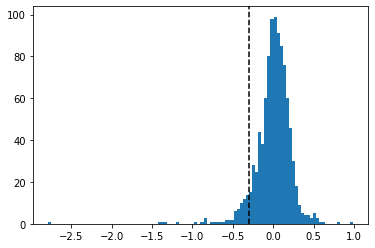

In [111]:
plt.hist(TICS_noise[:,2], bins=100)
plt.axvline(x=TICS_real[0][2], c='k', linestyle='--')

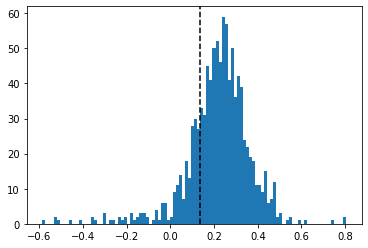

In [112]:
plt.hist(TICS_noise[:,3], bins=100)
plt.axvline(x=TICS_real[0][3], c='k', linestyle='--')

In [43]:
TICS_noise

array([[-0.15764084, -0.15663834,  0.03500942,  0.00693594],
       [-0.25997066, -0.21294557,  0.09720111, -0.12799314],
       [-0.14357544, -0.15689564, -0.42545655,  0.06779291],
       ...,
       [-0.10021687, -0.2687372 ,  0.03360779,  0.01419055],
       [-0.18187788, -0.22795784,  0.12571403,  0.19980995],
       [-0.10642525, -0.20473203,  0.08343101,  0.30406803]],
      dtype=float32)

In [23]:
trj_ref = data.val_trj
all_bonds = [(b[0].index, b[1].index) for b in trj.top.bonds]
bond_dists_r = md.compute_distances(trj_ref, all_bonds)
bond_dists_s = md.compute_distances(trj, all_bonds)
bond_rmsd = np.sqrt(np.mean((bond_dists_s - bond_dists_r) ** 2))
bond_rmsd

0.01571621

In [24]:
min_r, max_r = np.min(bond_dists_r, axis=0), np.max(bond_dists_r, axis=0)
correct_aa = np.sum((bond_dists_s < max_r) & (bond_dists_s > min_r), axis=1)
auc_aa = []
for i in range(len(all_bonds)):
    auc = np.mean(correct_aa > i)
    auc_aa.append(auc)
print(np.sum(auc_aa) / len(all_bonds))

0.49402414253991306


In [21]:
trj_ref = data.val_trj
all_bonds = [(b[0].index, b[1].index) for b in trj.atom_slice(data.cond_idxs).top.bonds]
bond_dists_r = md.compute_distances(trj_ref.atom_slice(data.cond_idxs), all_bonds)
bond_dists_s = md.compute_distances(trj.atom_slice(data.cond_idxs), all_bonds)
bond_rmsd = np.sqrt(np.mean((bond_dists_s - bond_dists_r) ** 2))
bond_rmsd

0.011759693

In [22]:
min_r, max_r = np.min(bond_dists_r, axis=0), np.max(bond_dists_r, axis=0)
correct_aa = np.sum((bond_dists_s < max_r) & (bond_dists_s > min_r), axis=1)
auc_aa = []
for i in range(len(all_bonds)):
    auc = np.mean(correct_aa > i)
    auc_aa.append(auc)
print(np.sum(auc_aa) / len(all_bonds))

0.8365366926614677


In [23]:
trj_ref = data.val_trj
all_bonds = [(b[0].index, b[1].index) for b in trj.top.bonds if 'hydrogen' in b[1].element]
bond_dists_r = md.compute_distances(trj_ref, all_bonds)
bond_dists_s = md.compute_distances(trj, all_bonds)
bond_rmsd = np.sqrt(np.mean((bond_dists_s - bond_dists_r) ** 2))
bond_rmsd

0.018569792

In [24]:
min_r, max_r = np.min(bond_dists_r, axis=0), np.max(bond_dists_r, axis=0)
correct_aa = np.sum((bond_dists_s < max_r) & (bond_dists_s > min_r), axis=1)
auc_aa = []
for i in range(len(all_bonds)):
    auc = np.mean(correct_aa > i)
    auc_aa.append(auc)
print(np.sum(auc_aa) / len(all_bonds))

0.18576284743051388


In [43]:
from tqdm.autonotebook import tqdm

In [44]:
frames = list()
for t in tqdm(trj_fnames):
    frame = md.load(t, top=trj.top)[0]
    frames.append(frame)

  0%|          | 0/267 [00:00<?, ?it/s]

In [54]:
frames_trj = md.join(frames).center_coordinates()

In [55]:
frames_trj.save_pdb('frame_heavy_trj.pdb')

In [56]:
md.load('data_mdshare/pentapeptide-impl-solv.pdb').center_coordinates().save_pdb('pentapeptide_pdb_center.pdb')